In [1]:
# External downloads (will need to be downloaded apart, packaged as a dataset in Kaggle an manually imported for the submission notebook)

INTERNET = False

if INTERNET:
    # --- Internet ON: ---
    ! pip install segmentation_models     #! pip download segmentation_models -d ./
    
else:
    # --- Internet OFF: ---
    ! pip install segmentation_models -f ../input/efficientnetb5weights --no-index


# Pretrained Model weights:
# https://github.com/Callidior/keras-applications/releases/download/efficientnet/efficientnet-b5_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5


Looking in links: ../input/efficientnetb5weights
Processing /kaggle/input/efficientnetb5weights/segmentation_models-1.0.1-py3-none-any.whl
Processing /kaggle/input/efficientnetb5weights/Keras_Applications-1.0.8-py3-none-any.whl
Processing /kaggle/input/efficientnetb5weights/efficientnet-1.0.0-py3-none-any.whl
Processing /kaggle/input/efficientnetb5weights/image_classifiers-1.0.0-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import utils as np_utils
from pathlib import Path
import albumentations as A
from time import time
import random

import segmentation_models as sm
from segmentation_models import Unet

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Segmentation Models: using `keras` framework.


In [3]:
INPUT_PATH = Path("../input/hubmap-organ-segmentation")
TRAIN_IMAGES_PATH = INPUT_PATH / "train_images"
TRAIN_CSV_PATH = INPUT_PATH / "train.csv"
TEST_IMAGES_PATH = INPUT_PATH / "test_images"
TEST_CSV_PATH = INPUT_PATH / "test.csv"
WEIGHTS_PATH = "../input/efficientnetb5weights/efficientnet-b5_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"

In [4]:
# UTILS
#https://www.kaggle.com/code/pestipeti/decoding-rle-masks/notebook
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return " ".join(str(x) for x in runs)


def rle2mask(mask_rle, shape=(3000,3000)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    return img.reshape(shape).T

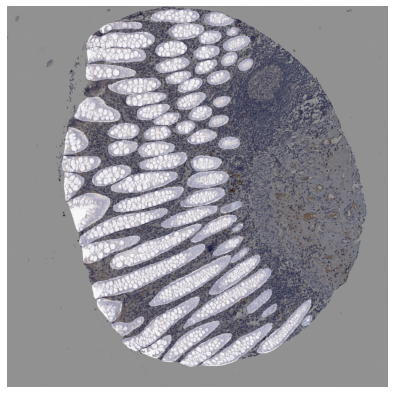

sizes: (800, 800, 3) (800, 800, 1)
sizes: (800, 800, 3) (800, 800, 1)
sizes: (800, 800, 3) (800, 800, 1)
sizes: (800, 800, 3) (800, 800, 1)
sizes: (800, 800, 3) (800, 800, 1)
sizes: (800, 800, 3) (800, 800, 1)
sizes: (800, 800, 3) (800, 800, 1)
sizes: (800, 800, 3) (800, 800, 1)
sizes: (800, 800, 3) (800, 800, 1)


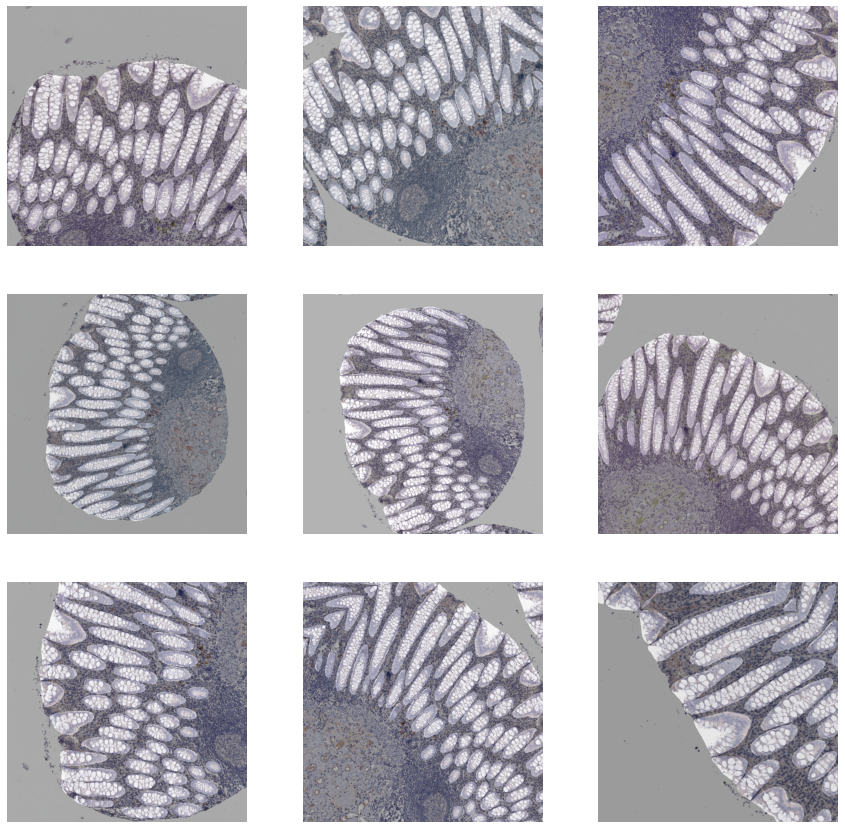

In [5]:
# Data Augmentation

train_df = pd.read_csv(TRAIN_CSV_PATH)

img_id = 11890
_image = tf.keras.utils.load_img(TRAIN_IMAGES_PATH / f"{img_id}.tiff", target_size=(3000, 3000))
_image = tf.keras.utils.img_to_array(_image, dtype="uint8")


_mask = rle2mask(train_df.loc[train_df.id == img_id].rle.values[0]).reshape((3000,3000,1))

plt.rcParams["figure.figsize"] = (7, 7)
plt.imshow(_image)
plt.imshow(_mask, alpha=0.4, cmap='gray')
plt.axis("off")
plt.show()


def transform_f(img_size):
    
    transform = A.Compose([
        A.OneOf(
            [
                #A.Affine(scale=0.8, mode=2, p=0.4),
                #A.CenterCrop(height=500, width=500, p=1),
                A.CenterCrop(height=2300, width=2300, p=1),
                A.CropNonEmptyMaskIfExists(height=2500, width=2500, p=1),
                A.CropNonEmptyMaskIfExists(height=2000, width=2000, p=1),
                A.CropNonEmptyMaskIfExists(height=1500, width=1500, p=1),
            ],
            p=0.7
        ),
        A.Resize(img_size, img_size),
        #A.ElasticTransform(p=0.95),
        #A.ShiftScaleRotate(p=0.95),
        A.PiecewiseAffine(scale=(0.005, 0.015), p=0.5),
        A.Rotate(limit=90, p=0.8),
        A.Flip(p=0.7),
        #A.RandomCrop(width=2000, height=2000),
        #A.RandomSizedCrop(min_max_height=(), height=3000, widht=3000),
        #A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.1, p=0.8)
    ])
    
    return transform


transform = transform_f(800)

grid_size = 3
fig, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 15))

for i in range(grid_size):
    for j in range(grid_size):

        transformed = transform(image=_image, mask=_mask)

        transformed_image = transformed["image"]
        transformed_mask = transformed["mask"]

        print("sizes:", transformed_image.shape, transformed_mask.shape)
        #ax[i][j].set_title("sizes:", transformed_image.shape, transformed_mask.shape)
        ax[i][j].imshow(transformed["image"])
        ax[i][j].imshow(transformed["mask"], alpha=0.3, cmap='gray')
        ax[i][j].axis("off")
    
fig.show()

In [6]:
# ./DataSequence.py

sm.set_framework("tf.keras")
sm.framework()


# SliceSequence resizes each image to img_Resize and takes slices as stored by the script Dfslices in the Dataframe
class SliceSequence(tf.keras.utils.Sequence):

    def __init__(self, batch_size, img_size, df, img_Resize = 0, shuffle = True):
        super().__init__()
        self.batch_size = batch_size
        self.img_size = img_size
        self.df = df
        self.img_Resize = img_Resize
        self.indexes = np.arange(0, int(np.floor(len(df) / batch_size)) * batch_size)
        if(shuffle):
            np.random.shuffle(self.indexes)


    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        ind = self.indexes[idx : idx+self.batch_size]

        x = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype="uint8")
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype="uint8")

        IdPrev = -1
        for j, (indexm, row) in enumerate(self.df.iloc[ind].iterrows()):
            if(IdPrev != int(row["id"])):
                img_path = TRAIN_IMAGES_PATH / (str(int(row["id"])) + ".tiff")
                if(self.img_Resize > 0):
                    img = tf.keras.utils.load_img(img_path, target_size=(self.img_Resize, self.img_Resize))
                else:
                    img = tf.keras.utils.load_img(img_path)
                img_array = tf.keras.utils.img_to_array(img, dtype="uint8")
            Xslice = int(row["Xslice"])
            Yslice = int(row["Yslice"])
            x[j] = img_array[Xslice : Xslice+self.img_size, Yslice : Yslice+self.img_size]

            # calculate mask
            if (IdPrev != int(row["id"])):
                w = int(row["img_width"])
                h = int(row["img_height"])
                rle = row["rle"]
                s = rle.split()
                starts, lengths = [np.asarray(t, dtype="int") for t in (s[0:][::2], s[1:][::2])]
                starts = starts - 1
                original_mask = np.zeros(h * w, dtype=np.uint8)
                for s, l in zip(starts, lengths):
                    original_mask[s:s + l] = 1
                original_mask = original_mask.reshape((h, w)).T
                original_mask = tf.keras.utils.array_to_img(original_mask[:, :, tf.newaxis], scale=False)

                # resize mask
                if (self.img_Resize > 0):
                    original_mask = original_mask.resize((self.img_Resize, self.img_Resize))
                mask_array = tf.keras.utils.img_to_array(original_mask, dtype="uint8")
            y[j] = mask_array[Xslice:Xslice+self.img_size, Yslice:Yslice+self.img_size]
            IdPrev = int(row["id"])
            
        return x.astype("float32") / 255, y
    
    
## ImSequence with a resize of each image to img_size
class ImSequence(tf.keras.utils.Sequence):

    def __init__(self, batch_size, img_size, df, transform=None, set_type="train"):
        super().__init__()
        self.batch_size = batch_size
        self.img_size = img_size
        self.df = df
        self.set_type = set_type
        self.img_path = TRAIN_IMAGES_PATH if (self.set_type == "train" or self.set_type == "val_test") else TEST_IMAGES_PATH
        self.transform = transform

        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    
    def __getitem__(self, idx):
        ind = np.arange(idx * self.batch_size, (idx + 1) * self.batch_size) % len(self.df)

        x = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype="uint8")
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype="uint8")

        for j, (indexm, row) in enumerate(self.df.iloc[ind].iterrows()):
            img_path = self.img_path / (str(row["id"]) + ".tiff")
            #img = tf.keras.utils.load_img(img_path, target_size=(self.img_size, self.img_size))

            # calculate mask
            if self.set_type == "train":
                
                img = tf.keras.utils.load_img(img_path, target_size=(3000, 3000))
                img_array = tf.keras.utils.img_to_array(img, dtype="uint8")
                
                w = row["img_width"]
                h = row["img_height"]
                rle = row["rle"]
                original_mask = rle2mask(rle)
                # we need at least three channels to save an image so here expand mask to (3000, 3000, 1)
                original_mask = tf.keras.utils.array_to_img(original_mask[:, :, tf.newaxis], scale=False)

                # resize mask
                #mask = original_mask.resize((self.img_size, self.img_size))
                #mask_array = tf.keras.utils.img_to_array(mask, dtype="uint8").reshape((self.img_size,self.img_size, 1))
                mask = original_mask.resize((3000, 3000))
                mask_array = tf.keras.utils.img_to_array(mask, dtype="uint8").reshape((3000, 3000, 1))
                
                # data augmentation                                    
                transformed = self.transform(image=img_array, mask=mask_array)
                transformed_image = transformed["image"]
                transformed_mask = transformed["mask"]
                
                x[j] = transformed_image
                y[j] = transformed_mask
                
            else:
                img = tf.keras.utils.load_img(img_path, target_size=(self.img_size, self.img_size))
                img_array = tf.keras.utils.img_to_array(img, dtype="uint8")
                
                if self.transform:
                    x = np.zeros((len(self.transform)+1, self.img_size, self.img_size, 3), dtype="uint8")
                    x[0] = img_array
                    
                    for j, transform_i in enumerate(self.transform):
                        transformed = transform_i(image=img_array)
                        transformed_image = transformed["image"]
                        x[j+1] = transformed_image
                    
                else:
                    x[j] = img_array 

        if self.set_type == "train":
            return x.astype("float32") / 255, y
            
        else:
            return x.astype("float32") / 255

2022-10-11 12:46:39.863021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 12:46:39.959105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 12:46:39.959949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 12:46:39.961087: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83/83 [==============================] - 299s 3s/step - loss: 0.3643 - f1-score: 0.2948 - val_loss: 0.7652 - val_f1-score: 0.4358


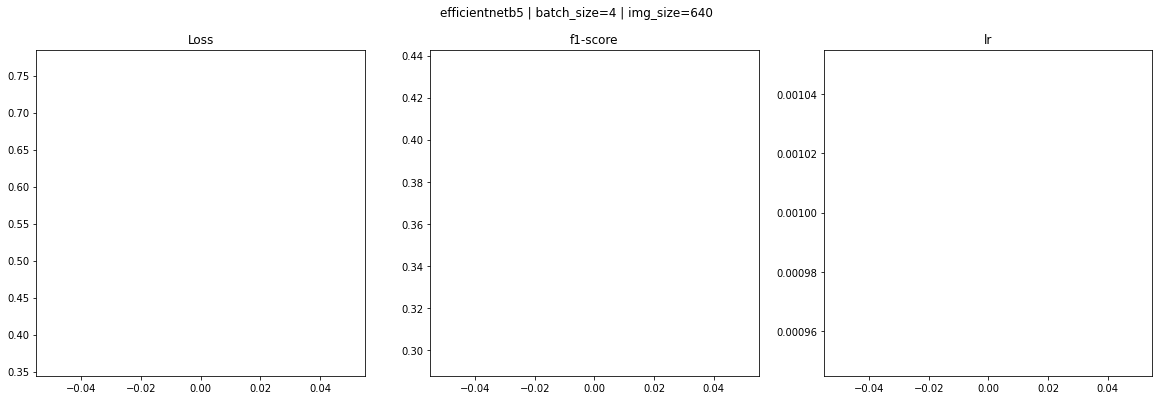

In [7]:
# ./ModelTrain.py

df_test = pd.read_csv(TEST_CSV_PATH)

# --- hparams ---
#LR = 0.0001
BACKBONE = "efficientnetb5"
BATCH_SIZE = 4
IMG_SIZE = 640
EPOCHS = 50 if len(df_test) > 16 else 1  # treak to avoid spending gpu time again on notebook saving run, then it will run fine at submission
VAL_SET_SIZE = 0.05


if INTERNET:
    # Internet ON:
    model = Unet(backbone_name=BACKBONE, encoder_weights="imagenet", encoder_freeze=True)

else:
    # Internet OFF:
    model = Unet(backbone_name=BACKBONE, encoder_weights=WEIGHTS_PATH, encoder_freeze=True)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

# compile keras model with defined optimozer, loss and metrics
model.compile("Adam", "binary_crossentropy", [sm.metrics.FScore()])


df = pd.read_csv(TRAIN_CSV_PATH)

# Filter the data related to the organ with which is going to be tested

# Number of samples taken for validation

NVal = int(np.floor(len(df) * VAL_SET_SIZE))

dfshuffle = df.iloc[np.random.permutation(len(df))]

dv = dfshuffle.iloc[-NVal:]
dt = dfshuffle.iloc[:-NVal]

transform = transform_f(IMG_SIZE)

## ImSequence with a resize of each image to img_size

Train = ImSequence(BATCH_SIZE, IMG_SIZE, dt, transform)
Val = ImSequence(BATCH_SIZE, IMG_SIZE, dv, transform)


## SliceSequence resizes each image to img_Resize and takes slices as stored by the script Dfslices in the Dataframe

#Train = SliceSequence(batch_size, img_size, dt, img_Resize=img_Resize,  shuffle=False)
#Val = SliceSequence(batch_size, img_size, dv, img_Resize=img_Resize, shuffle=False)


callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

history = model.fit(Train, epochs=EPOCHS, callbacks=callbacks, validation_data=Val)


# score plots
epochs = range(EPOCHS)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(20, 6))
ax0.set_title("Loss")
ax0.plot(epochs, history.history["loss"])
ax0.plot(epochs, history.history["val_loss"])
ax1.set_title("f1-score")
ax1.plot(epochs, history.history["f1-score"])
ax1.plot(epochs, history.history["val_f1-score"])
ax2.set_title("lr")
ax2.plot(epochs, history.history["lr"])
fig.suptitle(f"{BACKBONE} | batch_size={BATCH_SIZE} | img_size={IMG_SIZE}")
plt.show()

In [8]:
"""
Provisional val f1-score result logs:

- EffB7, batch_size=16, img_size=256, epochs=15      --> 0.56 aprox
- resnet18, batch_size=16, img_size=256, epochs=15   --> 0.1 (and worse) BUG
- resnet34, batch_size=8, img_size=256, epochs=15    --> 0.1 (and worse) BUG
- EffB6, batch_size=8, img_size=256, epochs=15       --> 0.65 
- EffB5, batch_size=4, img_size=512, epochs=15       --> 0.71 / TEST: 0.43

After applying DA in train and val:           (now the validation score is more similar to the competition test data) 
- EffB5, batch_size=4, img_size=512, epochs=25                                 --> 0.58 / TEST: 0.47 
- EffB5, batch_size=4, img_size=512, epochs=50                                 --> 0.67 / TEST: 0.43
- EffB3, batch_size=4, img_size=800, epochs=30, DA large+small crops/resizes   --> TEST: 0.46


"""

'\nProvisional val f1-score result logs:\n\n- EffB7, batch_size=16, img_size=256, epochs=15      --> 0.56 aprox\n- resnet18, batch_size=16, img_size=256, epochs=15   --> 0.1 (and worse) BUG\n- resnet34, batch_size=8, img_size=256, epochs=15    --> 0.1 (and worse) BUG\n- EffB6, batch_size=8, img_size=256, epochs=15       --> 0.65 \n- EffB5, batch_size=4, img_size=512, epochs=15       --> 0.71 / TEST: 0.43\n\nAfter applying DA in train and val:           (now the validation score is more similar to the competition test data) \n- EffB5, batch_size=4, img_size=512, epochs=25                                 --> 0.58 / TEST: 0.47 \n- EffB5, batch_size=4, img_size=512, epochs=50                                 --> 0.67 / TEST: 0.43\n- EffB3, batch_size=4, img_size=800, epochs=30, DA large+small crops/resizes   --> TEST: 0.46\n\n\n'

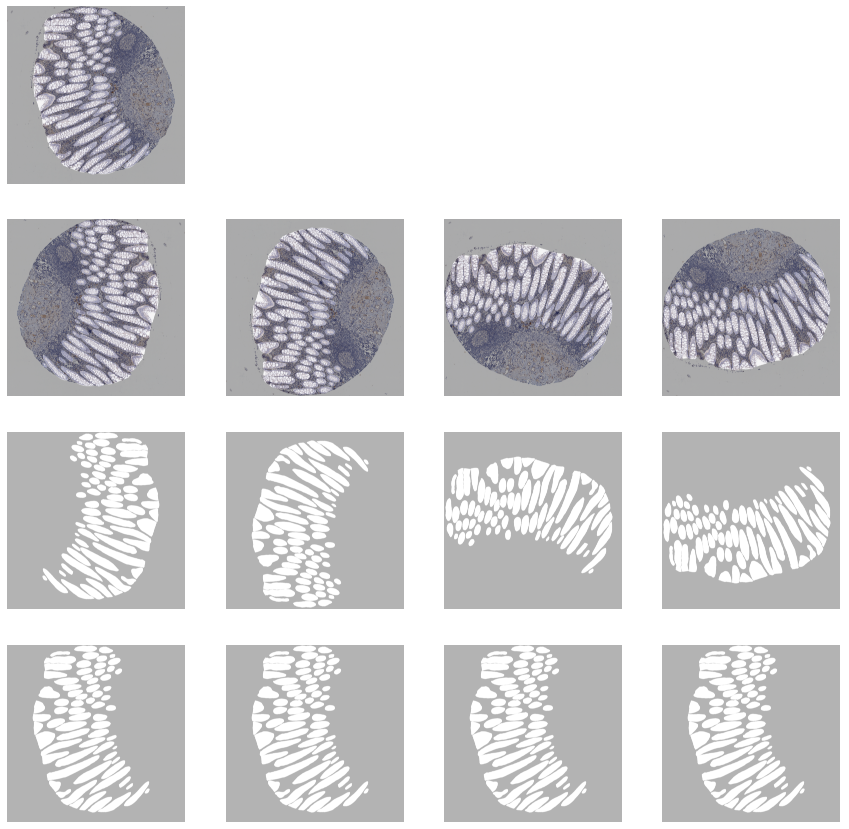

In [9]:
# Test Time Augmentation (tta)

# tta functions
tta_transforms = [
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.Transpose(p=1),
    A.Compose([
        A.Transpose(p=1),
        A.VerticalFlip(p=1),
    ])
]

tta_inv_transforms = [
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.Transpose(p=1),
    A.Compose([
        A.VerticalFlip(p=1),
        A.Transpose(p=1),
    ])
]
    
# Viz, test and debug
fig, ax = plt.subplots(nrows=4, ncols=len(tta_transforms), figsize=(15, 15))

ax[0][0].imshow(_image)
ax[0][0].imshow(_mask, alpha=0.3, cmap='gray')
for i in range(len(tta_transforms)):
    ax[0][i].axis("off")

for j, transform in zip(range(len(tta_transforms)), tta_transforms):

    transformed = transform(image=_image, mask=_mask)

    transformed_image = transformed["image"]
    transformed_mask = transformed["mask"]

    ax[1][j].imshow(transformed_image)
    ax[1][j].imshow(transformed_mask, alpha=0.3, cmap='gray')
    ax[1][j].axis("off")
    
    ax[2][j].imshow(transformed_mask, alpha=0.3, cmap='gray')
    ax[2][j].axis("off")
    
    # inverse
    transformed = tta_inv_transforms[j](image=np.concatenate((transformed_mask, transformed_mask, transformed_mask), axis=2), mask=transformed_mask)

    #transformed_image = transformed["image"]
    transformed_mask = transformed["mask"]

    #ax[2][j].imshow(transformed_image)
    ax[3][j].imshow(transformed_mask, alpha=0.3, cmap='gray')
    ax[3][j].axis("off")
     
fig.show()

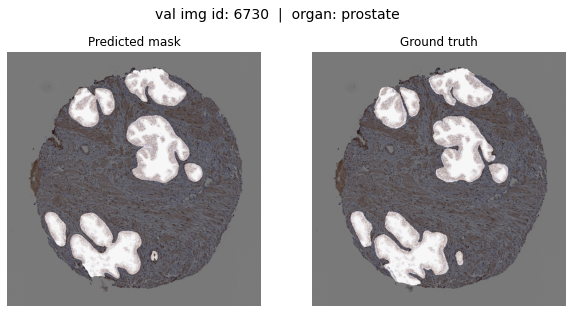

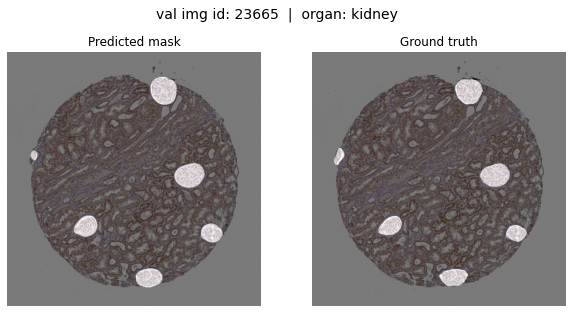

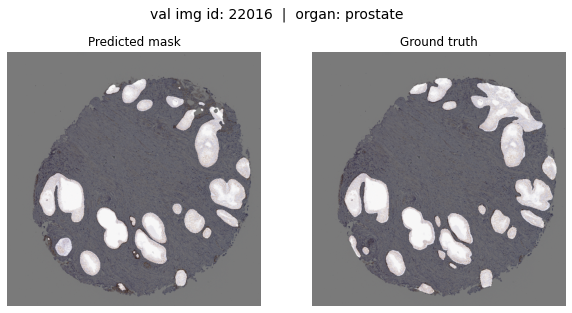

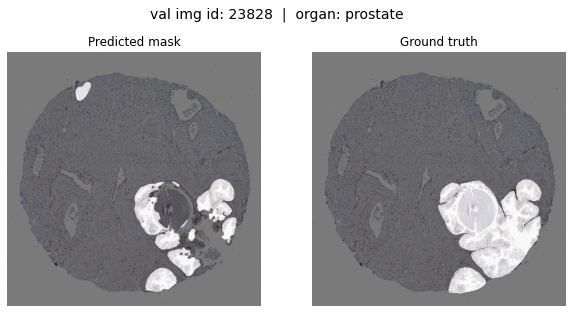

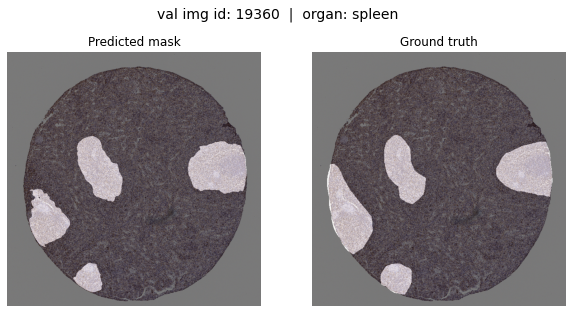

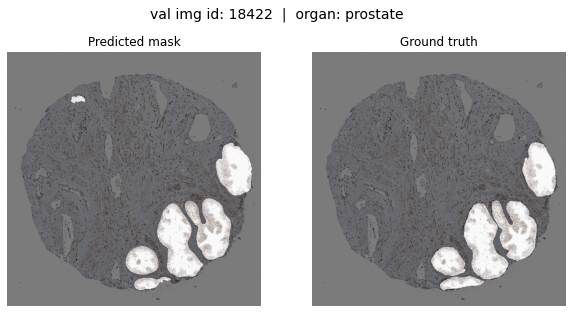

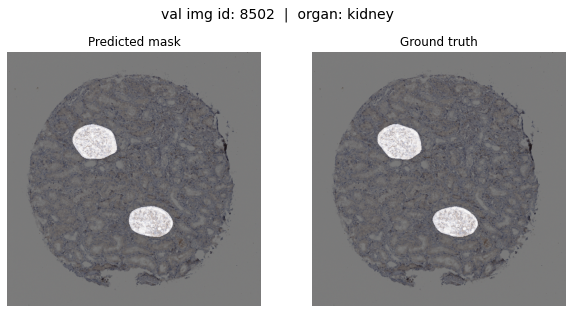

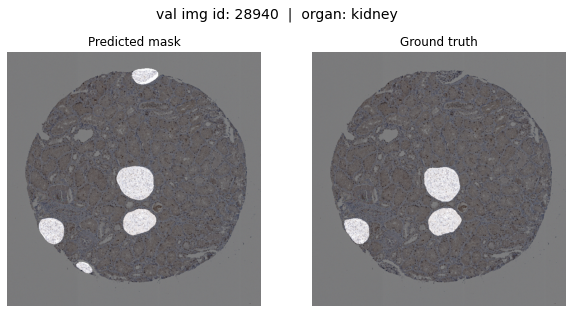

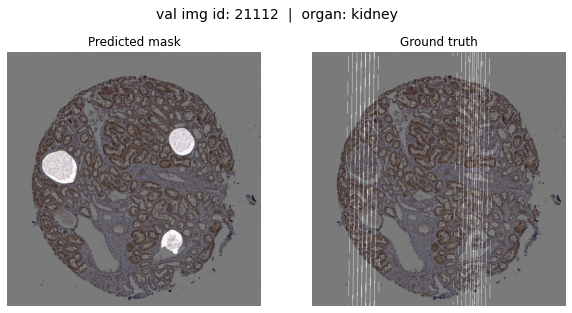

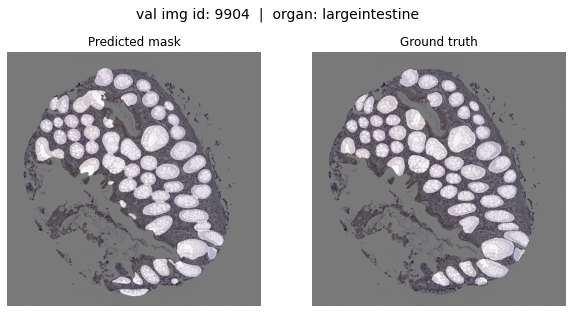

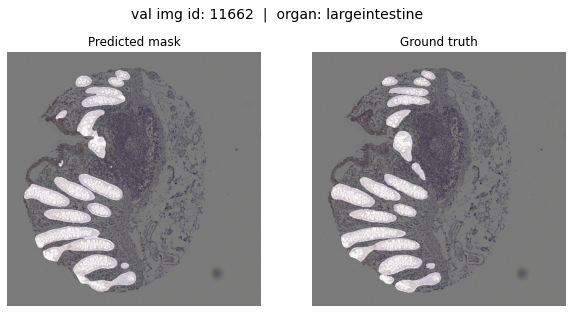

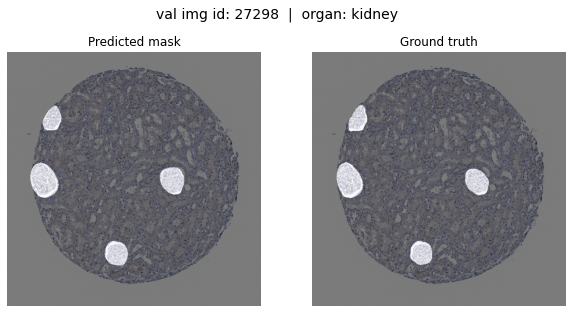

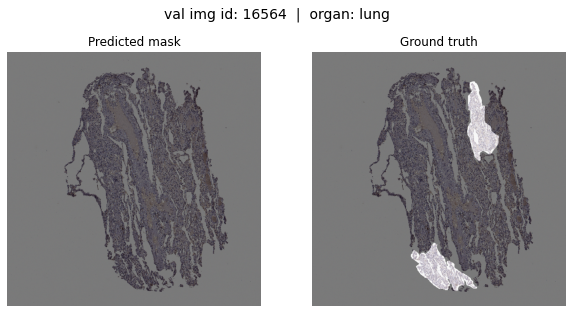

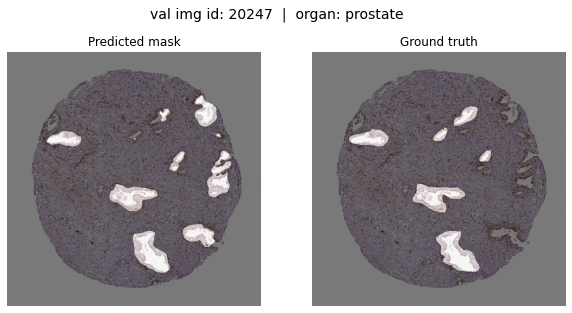

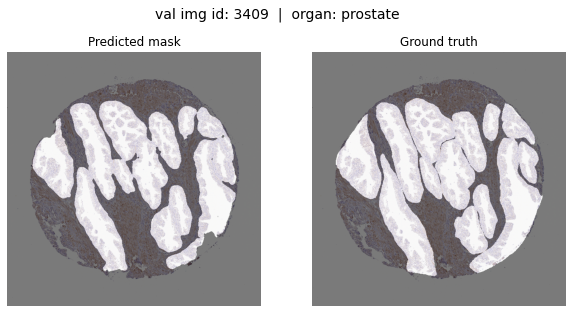

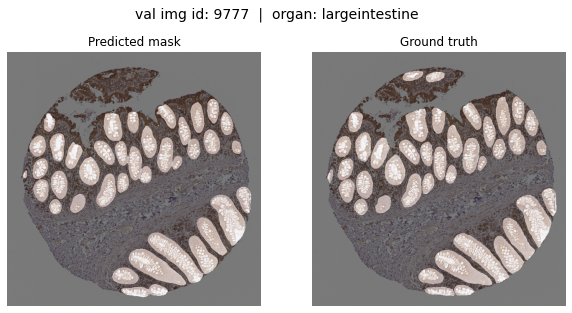

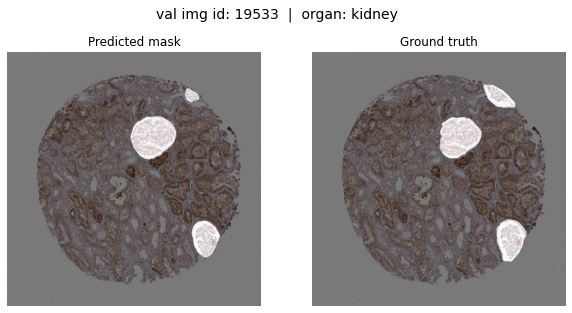

In [10]:
# Validation inference for debugging and demo
model.load_weights("../input/hubmap-trained-model/best_model.h5")

TEST_BATCH_SIZE = 1   # with tta transforms, the current logic just supports batches of one image

df_submission = pd.DataFrame(columns=["id", "rle"]).set_index("id")

df_test = dv.copy().reset_index()

# for debugging
add_id_debug = lambda : 0
if len(df_test) < 10:
    add_id_debug = lambda : np.random.randint(100)
    for i, o in zip(range(1,5), ["prostate", "lung", "kidney", "largeintestine"]):
        df_test.loc[i] = df_test.loc[0]
        df_test.loc[i, "organ"] = o
        
#df_test.loc[1] = df_test.iloc[0]  # DELETE debugging with 2 copies of the test image
remaining_test = len(df_test)

test_i = 0

while remaining_test > 0:
    batch_size = TEST_BATCH_SIZE if remaining_test >= TEST_BATCH_SIZE else remaining_test
    test_imgs = ImSequence(batch_size, IMG_SIZE, df_test.iloc[test_i : test_i+TEST_BATCH_SIZE], transform=tta_transforms, set_type="val_test")
    
    test_masks = model.predict(test_imgs)  # taking out round as we need the raw float values to first inv_transform, then avg and finally rounded in 0s and 1s
    
    test_id = df_test.iloc[test_i : test_i+TEST_BATCH_SIZE]["id"].values.tolist()[0]
    organ = df_test.iloc[test_i : test_i+TEST_BATCH_SIZE]["organ"].values.tolist()[0]
    
    for i, test_mask, inv_transform in zip(range(len(test_masks)), test_masks, [None]+tta_inv_transforms):
        if not inv_transform:
            continue
        else:
            inv_transformed = inv_transform(image=np.concatenate((test_mask, test_mask, test_mask), axis=2), mask=test_mask)
            test_masks[i] = inv_transformed["mask"]
            
    test_mask = test_masks.mean(axis=0).round()
            
    size = df_test.loc[df_test["id"] == test_id][["img_height", "img_width"]].values
    test_mask_i = test_mask.copy()

    test_mask_i = tf.keras.utils.array_to_img(test_mask_i, scale=False)

    # resize mask
    test_mask_i = test_mask_i.resize((size[0][0], size[0][1]))
    test_mask_i = tf.keras.utils.img_to_array(test_mask_i, dtype="uint8")
    rescaled_mask = test_mask_i.reshape((size[0][0], size[0][1], 1))

    test_rle = mask2rle(rescaled_mask)
    df_submission.loc[test_id+add_id_debug(), :] = [test_rle]

    # plot results vs ground truth
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax[0].imshow(test_imgs[0][0])
    ax[0].imshow(test_mask, alpha=0.5, cmap='gray')
    ax[0].axis("off")
    ax[0].set_title("Predicted mask")
    
    gt_mask = rle2mask(train_df.loc[train_df.id == test_id].rle.values[0]).reshape((3000,3000,1))
    
    transform_resize = A.Resize(IMG_SIZE, IMG_SIZE)
    resized = transform_resize(image=_image, mask=gt_mask)
    resized_gt_mask = resized["mask"]
    
    ax[1].imshow(test_imgs[0][0])
    ax[1].imshow(resized_gt_mask, alpha=0.5, cmap='gray')
    ax[1].axis("off")
    ax[1].set_title("Ground truth")

    fig.suptitle(f"val img id: {test_id}  |  organ: {organ}", fontsize=14)
    fig.show()
        
        
    remaining_test -= TEST_BATCH_SIZE
    test_i += TEST_BATCH_SIZE

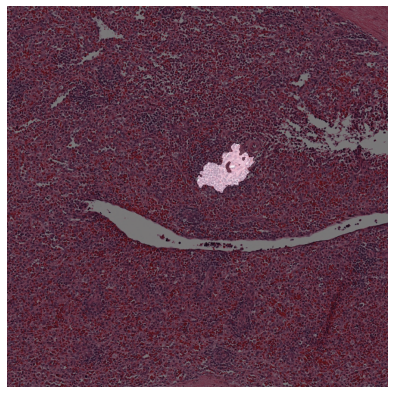

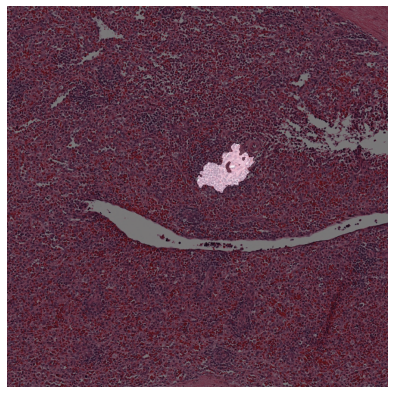

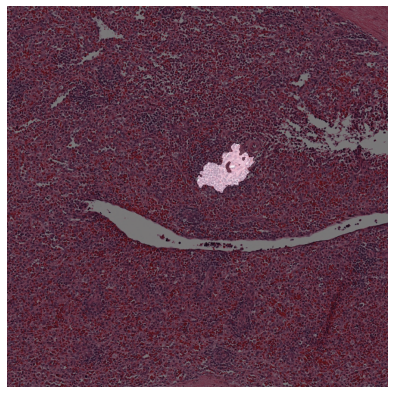

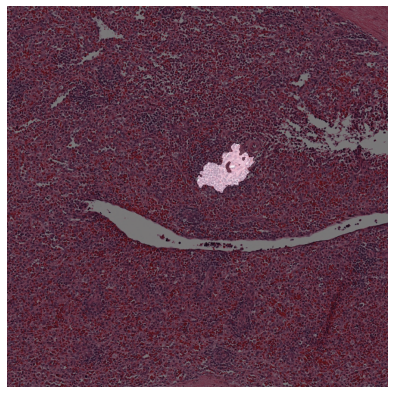

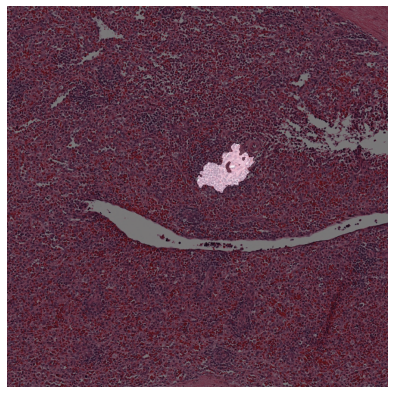

In [11]:
# Prediction and file submission
model.load_weights("../input/hubmap-trained-model/best_model.h5")

TEST_BATCH_SIZE = 1   # with tta transforms, the current logic just supports batches of one image

df_submission = pd.DataFrame(columns=["id", "rle"]).set_index("id")

df_test = pd.read_csv(TEST_CSV_PATH)

# for debugging
add_id_debug = lambda : 0
if len(df_test) < 10:
    add_id_debug = lambda : np.random.randint(100)
    for i, o in zip(range(1,5), ["prostate", "lung", "kidney", "largeintestine"]):
        df_test.loc[i] = df_test.loc[0]
        df_test.loc[i, "organ"] = o
        
#df_test.loc[1] = df_test.iloc[0]  # DELETE debugging with 2 copies of the test image
remaining_test = len(df_test)

test_i = 0

while remaining_test > 0:
    batch_size = TEST_BATCH_SIZE if remaining_test >= TEST_BATCH_SIZE else remaining_test
    test_imgs = ImSequence(batch_size, IMG_SIZE, df_test.iloc[test_i : test_i+TEST_BATCH_SIZE], transform=tta_transforms, set_type="test")
    
    test_masks = model.predict(test_imgs)  # taking out round as we need the raw float values to first inv_transform, then avg and finally rounded in 0s and 1s
    
    test_id = df_test.iloc[test_i : test_i+TEST_BATCH_SIZE]["id"].values.tolist()[0]
    
    for i, test_mask, inv_transform in zip(range(len(test_masks)), test_masks, [None]+tta_inv_transforms):
        if not inv_transform:
            continue
        else:
            inv_transformed = inv_transform(image=np.concatenate((test_mask, test_mask, test_mask), axis=2), mask=test_mask)
            test_masks[i] = inv_transformed["mask"]
            
    test_mask = test_masks.mean(axis=0).round()
            
    size = df_test.loc[df_test["id"] == test_id][["img_height", "img_width"]].values
    test_mask_i = test_mask.copy()

    test_mask_i = tf.keras.utils.array_to_img(test_mask_i, scale=False)

    # resize mask
    test_mask_i = test_mask_i.resize((size[0][0], size[0][1]))
    test_mask_i = tf.keras.utils.img_to_array(test_mask_i, dtype="uint8")
    rescaled_mask = test_mask_i.reshape((size[0][0], size[0][1], 1))

    test_rle = mask2rle(rescaled_mask)
    df_submission.loc[test_id+add_id_debug(), :] = [test_rle]

    if len(df_test) < 20:
        plt.imshow(test_imgs[0][0])
        plt.imshow(test_mask, alpha=0.5, cmap='gray')
        plt.axis("off")
        plt.show()
        
    remaining_test -= TEST_BATCH_SIZE
    test_i += TEST_BATCH_SIZE

In [12]:
df_submission

rle
id                                                      
10084  2040117 10 2042140 10 2044163 10 2046164 4 204...
10134  2040117 10 2042140 10 2044163 10 2046164 4 204...
10113  2040117 10 2042140 10 2044163 10 2046164 4 204...
10122  2040117 10 2042140 10 2044163 10 2046164 4 204...
10097  2040117 10 2042140 10 2044163 10 2046164 4 204...

In [13]:
df_submission.to_csv("submission.csv")

In [14]:
# --- Next steps: --- 

# - Adapt ImSequence to properly handle all test images  [DONE]
# - Resize back output mask from prediction, then transform to rle  [DONE]
# - Fill submission file with all rles from test images  [DONE]

# - Better data augmentation pipeline with Albumentations (follow example in github)  [DONE]

# - Train and predict with different models for each organ  [DONE (similar or worse results)]
# - Sliced dataset with proper sizes  
# - Research other backbones a part from efficientnet (ResNet was performing bad)
# - Try to improve dataloaders
# - Research about loss function and also model callbacks and checkpoints  [checkpoints DONE]
# - Implement model checkpointing to avoid long waitings for results (except for the final best submissions which should be entirely trained)  [DONE but not allowed in competition]
# - Copy other public code solutions with good scores